# Finding the needle in the haystack: Identifying rare events at the future Electron-Ion Collider

This project relates to physics at the proposed U.S. [Electron-Ion Collider](https://www.bnl.gov/bnlweb/pubaf/fact_sheet/pdf/EIC_Brochure.pdf) EIC. The main purpose of the EIC is to explore the inner workings of protons, neutrons, and nuclei at an unprecedented level of detail. In addition, it has the potential to find "[new physics](https://en.wikipedia.org/wiki/Physics_beyond_the_Standard_Model)", i.e. phenomena that have never been observed before. This project focuses on identifying one of these new phenomena in Monte Carlo simulations with the current design for an experiment at the EIC.

### Doing Experiments with Particle Colliders
A high-energy particle [collider](https://en.wikipedia.org/wiki/Collider) like the EIC accelerates charged particles to nearly the speed of light before making them collide. The collision typically creates multiple particles that fly away from the collision point.

Experiments at particle colliders are essentially giant cameras. They use various technologies to record the identity, energy, and direction of all the particles that come out of each collision. The experiment used for this project follows a typical design: To measure direction, electric charge, and momentum of charged particles, it use a magnetic field that bends the path of charged particles depending on their charge and momentum, combined with a tracking detector that measures the particle trajectory. To measure the direction and energy of particles (charged or neutral), it uses so-called calorimeters. Calorimeters measure the energy of particles by stopping the particle (i.e. the particle deposits all its energy in the calorimeter) and returning a signal that is proportional to the deposited energy. If multiple particles can be grouped together based on the direction they are flying in, they are considered a <a href="https://en.wikipedia.org/wiki/Jet_(particle_physics)">jet</a>. Different jet finding algorithms exist that apply differnt criteria for this grouping.

While many particles can be measured and identified directly, others decay so quickly that we can only measure their decay products. <a href="https://en.wikipedia.org/wiki/Tau_(particle)">Taus</a> are such quickly decaying particles. Even though we cannot detect them directly, we __can__ measure their decay products and use that information to identify the original tau.


### Searching for tau decays
The goal this study is to identify taus in Monte Carlo simulated EIC data. We focus on taus that decay into three charged [pions](https://en.wikipedia.org/wiki/Pion) (and a neutral pion and a neutrino, which escapes direct detection). These pions form a characteristically narrow and jet-like cone, which is typically narrower and contains fewer particles than the ubiquitous hadron jets. See the illustration below for a comparison between a typical hadron jet and a typical jet from a tau decaying into three charged pions. To identify taus, we need to find an effective way to distinguish tau jets from hadron jets.

<br>

<img src="figures/tau_signature.jpg" alt="Experimental signature of a tau lepton decaying into pions." style="width: 400px;"/>

The possibility to identify taus at the Electron-Ion Collider is exciting because it allows to search for the conversion of beam electrons into taus (which are heavier versions of electrons). Discovering such a conversion would significantly impact our understanding of nature. It is predicted by various theories of possible physics phenomena. So far, no experiment has seen this conversion, and the EIC could potentially detect it. But, it is challenging to identify with certainty the rare electron-proton collisions in wich the electron turns into a tau. If they occured, they would constitute roughly one in 100 million events recorded at the EIC.

### The data
This analysis is performed on Monte Carlo simulated data for an EIC experiment. The data are generated in two steps:

1. Simulation of the __physics process__, i.e. generating all the particles that result from the collision of an electron with a proton.
2. Simulation of the __detector response__ to the genreated particles, i.e. predicting what the real EIC experiment could actually measure and with what precision. This adds uncertainties reflecting the expected performance of the experiment to the simulated particles.

We use two input data files:
* `data/jets_lq_tau_3pi_r05_p250_e20.csv`: These are the signal events. The incoming electrons convert into taus, which subsequently decay into three charged pions. Jets are created from the collision, as well as the decay of the tau.
* `data/jets_dis_nc_r05_p250_e20.csv`: These are background events. Jets are created from the collision. The electrons keep their identity and can be detected after the collision.
* `data/jets_dis_cc_r05_p250_e20.csv`: These are background events. Jets are created from the collision. The electron converts into a neutrino that escapes detection, which is a process well described by the Standard Model. 

Each row in the data files corresponds to an identified jet. Descriptions of the individual columns are given in `data/jets_column_description.xls`.

# 0 Preprocessing

Import libraries.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set default matplotlib font. Define colors for matplotlib.

In [2]:
# set matplotlib font
font = {'family' : 'DejaVu sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

# define colors for matplotlib basen on Tableau10 Color blind palette
mycolors = [(0/256.,107/256.,164/256.),
            (255/256.,128/256.,14/256.),
            (171/256.,171/256.,171/256.),
            (89/256.,89/256.,89/256.),
            (95/256.,158/256.,209/256.),
            (200/256.,82/256.,0/256.)]

# 1 Reading and cleaning the data

Read simulated data for jets in events with (signal) and without (background) electron-to-tau conversion into Pandas dataframes. In addition to the jets actually coming from tau decays, the events in the signal sample also contain hadron jets, i.e. 'background'. Therefore, in the signal sample, we explicityl select and keep only those jets as signal which actually originate from a tau decay.

In [3]:
# read simulated data for electron-to-tau conversion
df_signal = pd.read_csv('data/jets_lq_tau_3pi_r05_p250_e20.csv')

# select only jets originating from a tau decay
df_signal = df_signal[ df_signal['evtgen_pid'] == 15]

# read data for background processes, i.e. electron does NOT convert to tau
df_background_cc = pd.read_csv('data/jets_dis_cc_r05_p250_e20.csv')
df_background_nc = pd.read_csv('data/jets_dis_nc_r05_p250_e20.csv')
df_background = pd.concat([df_background_cc,df_background_nc])

# exclude jets that originate from a scattered electron
df_background = df_background[ df_background['evtgen_pid'] != 11 ]

Add 'signal' colum to each dataframe, where 'signal=1' for signal (tau) jets and 'signal=0' for background jets. This will be our __target column__. Afterwards, merge df_signal and df_background into df_combined for easier usage and print the total number of signal and background events in the data.

In [4]:
# add signal columns
df_signal['signal'] = 1
df_background['signal'] = 0

# merge datframes
df_combined_raw = pd.concat([df_signal,df_background])

# count number of signal and background events in data
count_signal = len( df_combined_raw[ df_combined_raw['signal']==1 ] )
count_background =  len( df_combined_raw[ df_combined_raw['signal']==0 ] )

print( "Background events in data set: ", count_background )
print( "Signal events in data set:     ", count_signal )


Background events in data set:  15944
Signal events in data set:      7691


We need to drop some of the columns from the dataframe. The columns we drop are:
* columns with 'truth' information from the Monte Carlo simulation, i.e. columns containing information that a real experiment could not actually measure,
* columns that include information about the overall event beyond the properties of an individual jet,
* jetshpae_r90 and jetshpae_emcal_r90 because all values in those columns are 0.5 and 0.0, respectively, which hints that they were not filled properly, and
* Row, Instance, event, jet_id because they are event and jet identifiers but not measurements.

In [5]:
# columns with truth information
drop_columns_truth = ['is_lq_event','neutrino_pt','evtgen_pid','evtgen_ptotal','evtgen_etotal',
                       'evtgen_theta','evtgen_phi','evtgen_eta','evtgen_decay_prong','evtgen_decay_hcharged',
                       'evtgen_decay_lcharged']

# columns with overall event information
drop_columns_event = ['Et_miss','Et_miss_phi','reco_tau_eta',
                      'reco_tau_found','reco_tau_is_tau','reco_tau_phi','reco_tau_ptotal']

# more columns to drop because the values are not filled poperly or only used internally by simulation code 
drop_columns_var = ['Row','Instance','event','jet_id','jetshape_r90','jetshape_emcal_r90']

# drop these columns from dataframe
df_combined = df_combined_raw.copy()
df_combined.drop( drop_columns_truth, axis=1, inplace=True )
df_combined.drop( drop_columns_event, axis=1, inplace=True )
df_combined.drop( drop_columns_var,   axis=1, inplace=True )

Remove all rows with NAN entries. Print number of signal and bakground events left.

In [6]:
# drop rows with NAN
df_combined.dropna(inplace=True)

# print number of signal and background events left
count_signal_clean = len( df_combined[ df_combined['signal']==1 ] )
count_background_clean =  len( df_combined[ df_combined['signal']==0 ] )

print( "Background events in clean data set: ", count_background_clean )
print( "Signal events in clean data set:     ", count_signal_clean )

Background events in clean data set:  15450
Signal events in clean data set:      7685


### Checking the number of tracks found for each jet
As mentioned in the introduction, we are trying to specifically identify taus that decay into three charged pions. In addition, these taus need to have negative electric charge, because they converted from negatively charged electrons and electric charge has to be conserved. In other words, we are looking for jets that include exactly three charged tracks and the charges of those tracks add up to '-1'. The histograms below show the distribution of the __number of charged tracks (tracks_count_R)__ and the __sum of the charges of the charged tracks (tracks_chargesum_R)__ in signal and background jets of our data sample.

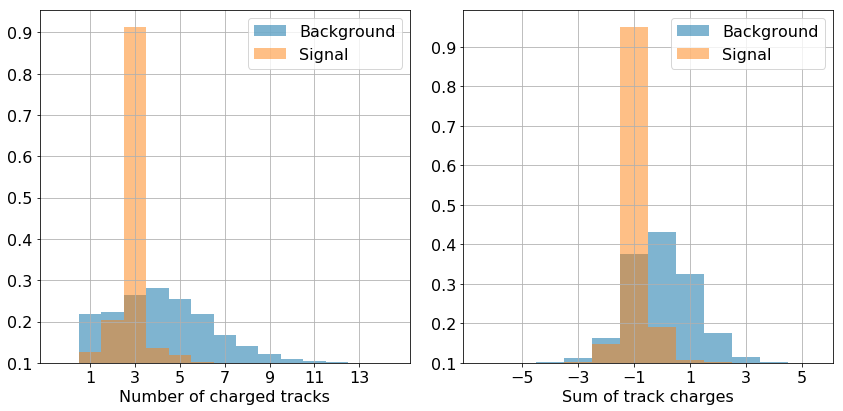

In [7]:
# quick way to plot histograms grouped by signal and background using the 'by' argument:
#df_combined.hist(column="tracks_count_R", by="signal", bins=50, color=mycolors[0], alpha=0.5)

# make nicer histograms
# create figure
plt.figure(figsize=(12,6))

# define bin ranges
bins_tracks_count = np.arange(-0.5,15.5,1)
bins_tracks_chargesum = np.arange(-6.5,6.5,1)

# force integer bin labels
xint_tracks_count = range(1,15,2)
xint_tracks_chargesum = range(-5,6,2)

# plot number of charged tracks and charge sum of all tracks in signal and background jets
# pass 'ax=ax' argument to histogram to plot it onto subfigure
# pass 'bottom' argument to histogram to allow for logarithmic axis with ax.set_yscale('log')
ax = plt.subplot(1,2,1)
df_combined[df_combined['signal']==0].hist("tracks_count_R", bottom=0.1, bins=bins_tracks_count, density=1, ax=ax, color=mycolors[0], label='Background', alpha=0.5)
df_combined[df_combined['signal']==1].hist("tracks_count_R", bottom=0.1, bins=bins_tracks_count, density=1, ax=ax, color=mycolors[1], label='Signal', alpha=0.5)
ax.set_title('')
ax.set_xlabel("Number of charged tracks")
ax.set_xticks(xint_tracks_count)
plt.legend(loc='upper right')


# plot charge sum of all tracks in signal and background jets
ax = plt.subplot(1,2,2)
df_combined[df_combined['signal']==0].hist("tracks_chargesum_R", bottom=0.1, bins=bins_tracks_chargesum, density=1, ax=ax, color=mycolors[0], label='Background', alpha=0.5)
df_combined[df_combined['signal']==1].hist("tracks_chargesum_R", bottom=0.1, bins=bins_tracks_chargesum, density=1, ax=ax, color=mycolors[1], label='Signal', alpha=0.5)
ax.set_title('')
ax.set_xlabel("Sum of track charges")
ax.set_xticks(xint_tracks_chargesum)
plt.legend(loc='upper right')

#tight layout
plt.tight_layout()

plt.show()

More than 90% of signal events show exactly 3 tracks with a chargesum of -1, as expected. However, some signal events do not. This is because the jet reconstruction algorithms uses data from realistic detector simulations as input. In other words, effects of tracks misidentification, missed tracks, and additional 'ghost' tracks are included. Just like in a real experiment. Improving these is a topic of ongoing studies and beyond the scope of this particular study.

We could select only jets that have __exactly three charged tracks__ for further analysis. However, we are working with a relatively small size background sample, so we keep all background jets and signal jets for now.

In [8]:
# keep all jets for further analysis
df_select = df_combined.copy()

# count number of signal and background events in selected data
count_signal_select     = len( df_select[ df_select['signal']==1 ] )
count_background_select = len( df_select[ df_select['signal']==0 ] )

print( "Background events in selected data: %d (%.1f percent of all background jets)" %
      (count_background_select, 100*count_background_select/count_background) )
print( "Signal events in selected data: %d (%.1f percent of all signal jets)" %
      (count_signal_select, 100*count_signal_select/count_signal) )
print("")
print("With this selection, we keep \n %.1f percent of all signal (tau) jets and \n %.1f percent of all background (hadron) jets \nfor furhter analysis."
      % ( 100*count_signal_select/count_signal , 100*count_background_select/count_background ) )

Background events in selected data: 15450 (96.9 percent of all background jets)
Signal events in selected data: 7685 (99.9 percent of all signal jets)

With this selection, we keep 
 99.9 percent of all signal (tau) jets and 
 96.9 percent of all background (hadron) jets 
for furhter analysis.


We now have a cleaned data set with jets from tau decays (signal) and hadron jets (background). Next, we move on to look at more jet properties and engineering and selecting features that allow us to separate signal (tau) jets from background (hadron) jets.

# 2 Feature engineering

### Radial jet energy distribution
The columns
* jetshape_econe_r01
* jetshape_econe_r02
* jetshape_econe_r03
* jetshape_econe_r04
* jetshape_econe_r05

all contain the energy found within a cone of different radii around the jet axis. The suffix indicates the cone size, with higher numbers corresponding to larger cone sizes. Therfore, for example, jetshape_econe_r04 includes all energy accounted for in the smaller cone jetshape_econe_r02. These columns are highly correlated with each other and the colum jet_etotal, which is the total energy associated with the jet, as shown in the following plots:

,jet_etotal,jetshape_econe_r01,jetshape_econe_r02,jetshape_econe_r03,jetshape_econe_r04,jetshape_econe_r05
jet_etotal,1.000000,0.809111,0.944314,0.984889,0.993920,0.989741
jetshape_econe_r01,0.809111,1.000000,0.918253,0.861938,0.824409,0.799778
jetshape_econe_r02,0.944314,0.918253,1.000000,0.976667,0.953633,0.935294
jetshape_econe_r03,0.984889,0.861938,0.976667,1.000000,0.990242,0.977538
jetshape_econe_r04,0.993920,0.824409,0.953633,0.990242,1.000000,0.993841
jetshape_econe_r05,0.989741,0.799778,0.935294,0.977538,0.993841,1.000000


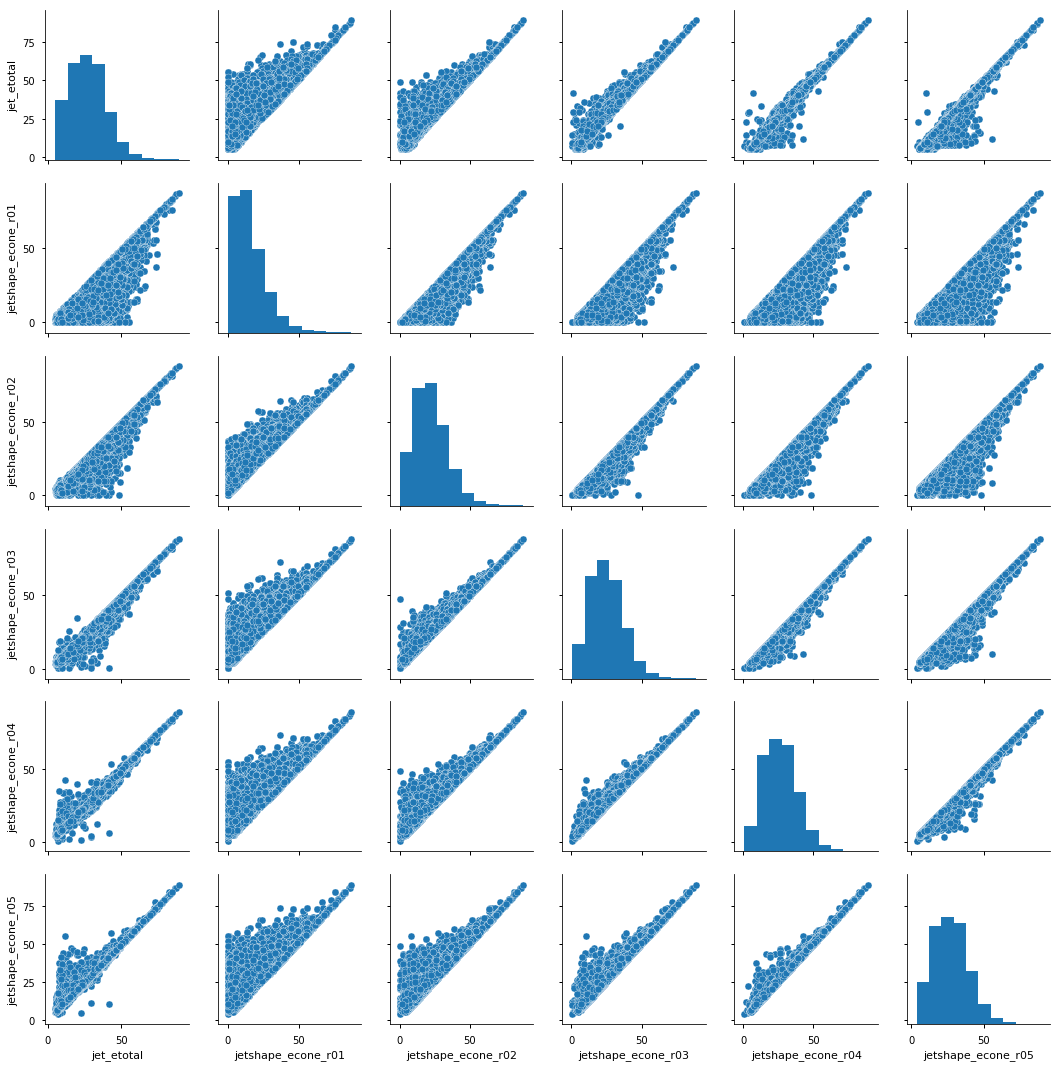

In [9]:
# array of columns to be checked for correlations
jetshape_econes = [
    'jet_etotal',
    'jetshape_econe_r01',
    'jetshape_econe_r02',
    'jetshape_econe_r03',
    'jetshape_econe_r04',
    'jetshape_econe_r05',
]

# plot pairwise correlations
with sns.plotting_context("notebook", font_scale=1.0, rc={"axes.axesbelow": False}):
    sns.pairplot( df_select[jetshape_econes] )
    
# print correlations table
df_select[jetshape_econes].corr()

Normalizing energy in cones to energy in largest cone r_05. These variables relate to how the energy in the jet is distributed radially, i.e. if it is all concentrated close to the central axis or spread out across the size of the jet. For the narrower tau jets, we would expect the energy to be concentrated around the center of the jet.

In [10]:
df_select['jetshape_econe_r01_over_r05'] = df_select['jetshape_econe_r01'] / df_select['jetshape_econe_r05']
df_select['jetshape_econe_r02_over_r05'] = df_select['jetshape_econe_r02'] / df_select['jetshape_econe_r05']
df_select['jetshape_econe_r03_over_r05'] = df_select['jetshape_econe_r03'] / df_select['jetshape_econe_r05']
df_select['jetshape_econe_r04_over_r05'] = df_select['jetshape_econe_r04'] / df_select['jetshape_econe_r05']

,jet_etotal,jetshape_econe_r01_over_r05,jetshape_econe_r02_over_r05,jetshape_econe_r03_over_r05,jetshape_econe_r04_over_r05
jet_etotal,1.000000,0.367449,0.368994,0.383598,0.362925
jetshape_econe_r01_over_r05,0.367449,1.000000,0.806186,0.658698,0.494534
jetshape_econe_r02_over_r05,0.368994,0.806186,1.000000,0.855869,0.663205
jetshape_econe_r03_over_r05,0.383598,0.658698,0.855869,1.000000,0.828625
jetshape_econe_r04_over_r05,0.362925,0.494534,0.663205,0.828625,1.000000


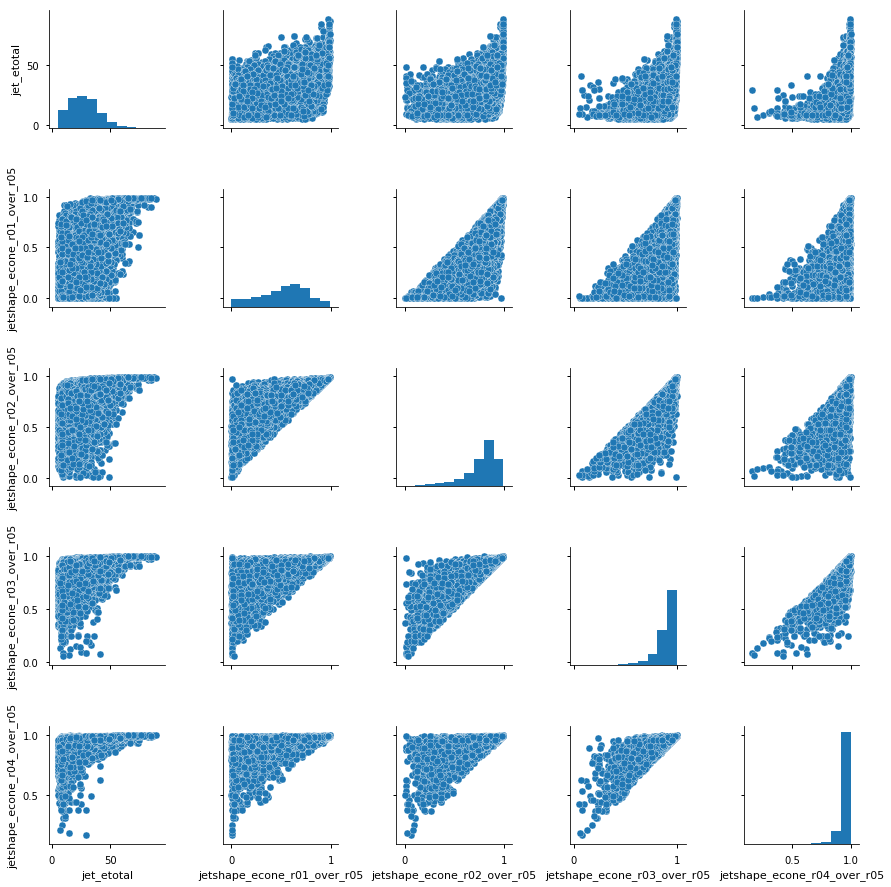

In [11]:
# array of columns to be checked for correlations
jetshape_econes = [
    'jet_etotal',
    'jetshape_econe_r01_over_r05',
    'jetshape_econe_r02_over_r05',
    'jetshape_econe_r03_over_r05',
    'jetshape_econe_r04_over_r05',
]

# plot pairwise correlations
with sns.plotting_context("notebook", font_scale=1.0, rc={"axes.axesbelow": False}):
    sns.pairplot( df_select[jetshape_econes] )
    
# print correlations table
df_select[jetshape_econes].corr()

The Pearson correlation factor between the normalized cone energies is significantly smaller than for the absolute energies in these jet cones. The newly created variables seems like a good addition to the set of features we consider, so we keep them.

### Electromagnetic energy fraction
Similar to the columns we just looked at, the columns
* jetshape_emcal_econe_r01
* jetshape_emcal_econe_r02
* jetshape_emcal_econe_r03
* jetshape_emcal_econe_r04
* jetshape_emcal_econe_r05

containe the energy measured in the elctromagnetic calorimeter (one specific subsystem to measure particle energies) within cones of different radii around the jet axis. This energy is included in the jetshape_econe variables, so again there is a high correltion and we can reduce this cirrelation by defining a ratio variable __jetshape_emratio__. The fraction of energy deposited in the electromagnetic calorimeter is a measure of the electromagnetic content of the jet, in other words it again gives more information that just a single energy measurement by itself. So we add __jetshape_emratio__ to our feature columns.

In [12]:
# define new ratio column
df_select['jetshape_emratio'] = df_select['jetshape_emcal_econe_r02'] / df_select['jetshape_econe_r02']

df_select[['jetshape_emcal_econe_r02','jetshape_econe_r02','jetshape_emratio']].corr()

,jetshape_emcal_econe_r02,jetshape_econe_r02,jetshape_emratio
jetshape_emcal_econe_r02,1.000000,0.832670,0.683157
jetshape_econe_r02,0.832670,1.000000,0.267626
jetshape_emratio,0.683157,0.267626,1.000000


# 3 Establishing a baseline for tau identification with a cut based selection

Ee choose a few of the feature columns and apply cuts to select signal (tau) jets from the combined sample of signal and background (hadron) jets. The efficiency and purity of these cuts will give us a baseline for training and testing machine learning algorithms so separate signal (tau) jets from background (hadron) jets.

Plot the distributions of the feature columsn used for cut based selection of tau (signal) events for the signal and background events. Vertical green lines indicate the thresholds for cuts.

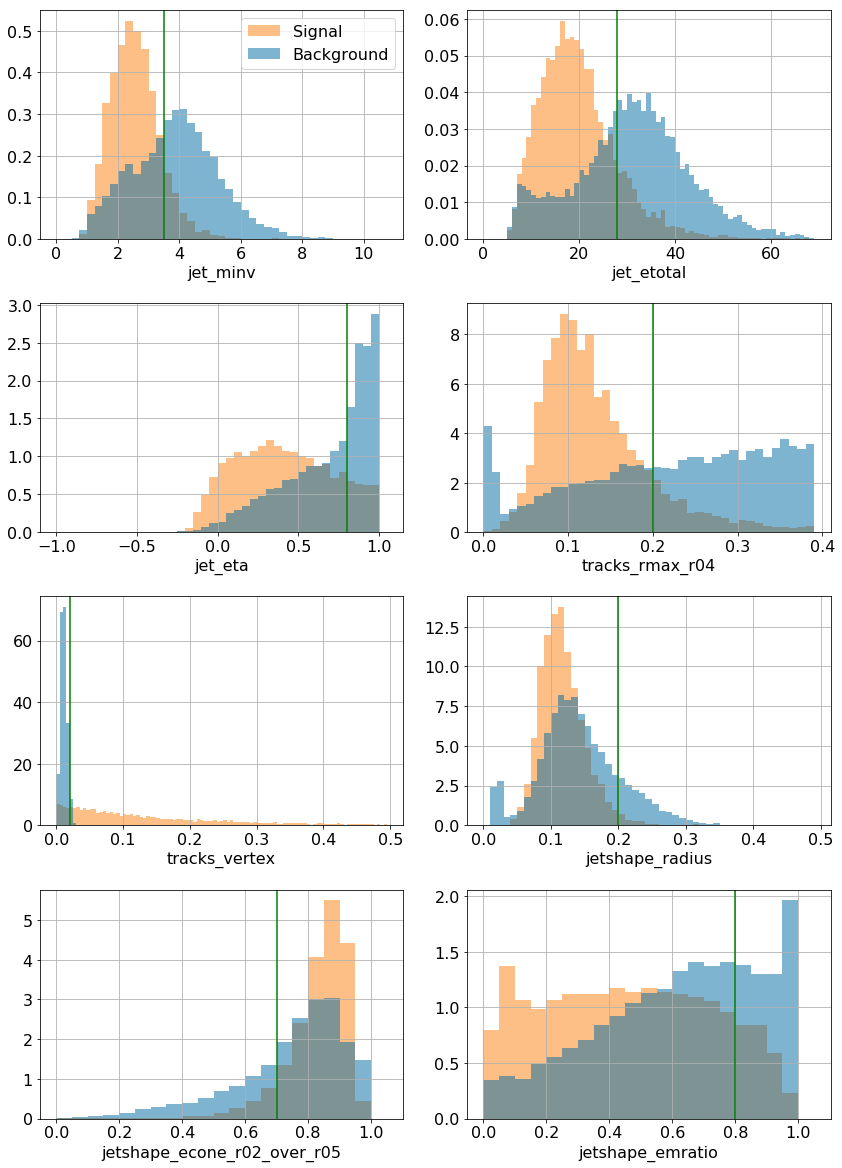

In [13]:
# list of features for cut based selection
cut_cols = ['jet_minv', 'jet_etotal', 'jet_eta',
            'tracks_rmax_r04', 'tracks_vertex', 'jetshape_radius',
            'jetshape_econe_r02_over_r05', 'jetshape_emratio']

# define bins for each feature
plot_bins = [np.arange(0,11,0.25), np.arange(0,70,1), np.arange(-1,1.1,0.05),
             np.arange(0,0.4,0.01), np.arange(0,0.5,0.005), np.arange(0,0.5,0.01),
             np.arange(0,1.1,0.05), np.arange(0,1.1,0.05)]

# define thresholds for signal (tau) selection
cut_thresholds = [3.5, 28, 0.8,
                  0.2, 0.02, 0.2,
                  0.7, 0.8]

# create figure
plt.figure(figsize=(12,20))

# plot signal and background histograms for each feature
for idx, col_i in enumerate( cut_cols ):    
    ax = plt.subplot(5,2,idx+1)
    df_select[df_select['signal']==1].hist(col_i, bins=plot_bins[idx], ax=ax,
                                               density=True, color=mycolors[1], label='Signal', alpha=0.5)
    df_select[df_select['signal']==0].hist(col_i, bins=plot_bins[idx], ax=ax,
                                               density=True, color=mycolors[0], label='Background', alpha=0.5)
    ax.set_title('')
    ax.set_xlabel(col_i)
    
    # plot line for cut threshold
    plt.axvline(x=cut_thresholds[idx], color='green')
    
    # only plot legend in first subfigure
    if ( idx == 0 ):
        plt.legend(loc='upper right')

#tight layout
plt.tight_layout()
plt.show()

In [14]:
# apply manual cuts to dataframe
df_cut = df_select[( df_select['jet_minv'] < cut_thresholds[0] ) &
                   ( df_select['jet_etotal'] < cut_thresholds[1] ) &
                   ( df_select['jet_eta'] < cut_thresholds[2] ) &
                   ( df_select['tracks_rmax_r04'] < cut_thresholds[3] ) &
                   ( df_select['tracks_vertex'] > cut_thresholds[4] ) &
                   ( df_select['jetshape_radius'] < cut_thresholds[5] ) &
                   ( df_select['jetshape_econe_r02_over_r05'] > cut_thresholds[6] ) &
                   ( df_select['jetshape_emratio'] < cut_thresholds[7] )
                  ]

# count background and signal jets left after cut
background_select_cut = len( df_cut[ df_cut['signal'] == 0 ] )
signal_select_cut = len( df_cut[ df_cut['signal'] == 1 ] )

print( "True positives (signal events in selected data after applying manual cuts):\n %d (%.1f percent of all signal jets)" %
      (signal_select_cut, 100*signal_select_cut/count_signal_select) )

print( "False positives (background events in selected data after applying manual cuts):\n %d (%.1f percent of all background jets)" %
      (background_select_cut, 100*background_select_cut/count_background_select) )


True positives (signal events in selected data after applying manual cuts):
 3488 (45.4 percent of all signal jets)
False positives (background events in selected data after applying manual cuts):
 22 (0.1 percent of all background jets)


After applying the set of manual cuts defined above, 45% of the true signal events are identified as signal events (true positives), while only 0.1% of background jets pass this cut (false positives).

From the histograms above, it looks like the track_vertex cut provides the strongest separation between signal (tau) and background (hadron) jets. Let's see what the cut only on this feature yields:

In [15]:
# apply manual cuts to dataframe
df_cut_vertex = df_select[ df_select['tracks_vertex'] > cut_thresholds[4] ]

# count background and signal jets left after cut
background_select_cut_vertex = len( df_cut_vertex[ df_cut_vertex['signal'] == 0 ] )
signal_select_cut_vertex = len( df_cut_vertex[ df_cut_vertex['signal'] == 1 ] )

print( "True positives (signal events in selected data after applying only vertex cut):\n %d (%.1f percent of all signal jets)" %
      (signal_select_cut_vertex, 100*signal_select_cut_vertex/count_signal_select) )

print( "False positives (background events in selected data after applying only vertex cut):\n %d (%.1f percent of all background jets)" %
      (background_select_cut_vertex, 100*background_select_cut_vertex/count_background_select) )

True positives (signal events in selected data after applying only vertex cut):
 6794 (88.4 percent of all signal jets)
False positives (background events in selected data after applying only vertex cut):
 851 (5.5 percent of all background jets)


As we suspected, this cut alone removes most of the background jets, leaving only 5% false positives and 88% true positives. While a high true positives rate is important when looking for rare events in data at the Electron-Ion Collider, a low false positive rate is actually much more critical. As mentioned in the introduction, the models for the process we are looking for predict that the background events will be more than 100 million times more abundant than the signal events.

In the next section, we will see how using machine learning algorithms can improve the true positive and false positive rates for identifying signal (tau) jets in our simulated data.

# 4 Training algorithm for tau jet classification

### Defining some useful functions for evaluating machine learning prediction performance

In [16]:
def true_positives( y_true, y_predict ):
    tp_filter = (y_predict == 1) & (y_true == 1)
    tp = len(y_predict[tp_filter])
    return(tp)

def false_positives( y_true, y_predict ):
    fp_filter = (y_predict == 1) & (y_true == 0)
    fp = len(y_predict[fp_filter])
    return(fp)

def true_negatives( y_true, y_predict ):
    tn_filter = (y_predict == 0) & (y_true == 0)
    tn = len(y_predict[tn_filter])
    return(tn)

def false_negatives( y_true, y_predict ):
    fn_filter = (y_predict == 0) & (y_true == 1)
    fn = len(y_predict[fn_filter])
    return(fn)

def print_efficiencies( y_train, y_train_predict, y_test, y_test_predict ):
    
    train_all_positives = len(y_train[ y_train == 1 ])
    train_all_negatives = len(y_train[ y_train == 0 ])
    test_all_positives = len(y_test[ y_test == 1 ])
    test_all_negatives = len(y_test[ y_test == 0 ])
    
    print('Model train/test true positives: %.3f / %.3f (%.5f / %.5f)'
      % ( true_positives( y_train, y_train_predict ) ,
          true_positives( y_test, y_test_predict ) ,
          true_positives( y_train, y_train_predict ) / train_all_positives,
          true_positives( y_test, y_test_predict ) / test_all_positives ) )

    print('Model train/test false positives %.3f / %.3f (%.5f / %.5f)'
      % ( false_positives( y_train, y_train_predict ) ,
          false_positives( y_test, y_test_predict ) ,
          false_positives( y_train, y_train_predict ) / train_all_negatives,
          false_positives( y_test, y_test_predict ) / test_all_negatives ) )

    print('Model train/test true negatives %.3f / %.3f'
      % ( true_negatives( y_train, y_train_predict ) ,
          true_negatives( y_test, y_test_predict ) ) )

    print('Model train/test false negatives %.3f / %.3f'
      % ( false_negatives( y_train, y_train_predict ) ,
          false_negatives( y_test, y_test_predict ) ) )
    return

### Splitting data into train and test sample

Splitting the data into one data set for training and one for testing machine learning algorithms for tau classification:

In [17]:
# create a random mask to select events from dataframes
msk = np.random.rand( len(df_select) ) < 0.2

# use mask to select events for training dataframe and complimentary test dataframe
df_train = df_select[msk]
df_test = df_select[~msk]

print( "Background events in training set: ", len( df_train[ df_train['signal']==0 ] ) )
print( "Signal events in training set:     ", len( df_train[ df_train['signal']==1 ] ) )
print( "Background events in testing set:  ", len( df_test[ df_test['signal']==0 ] ) )
print( "Signal events in testing set:      ", len( df_test[ df_test['signal']==1 ] ) )

Background events in training set:  3006
Signal events in training set:      1516
Background events in testing set:   12444
Signal events in testing set:       6169


###  Select target column and feature columns

In [18]:
# target column
target_col = 'signal'

# feature columns
feature_cols = [
    'jet_minv',
    'jet_etotal',
#    'jet_eta',
    'tracks_rmax_r04',
    'tracks_vertex',
    'jetshape_radius',
    'jetshape_rms',
#    'jetshape_logradius',
#    'jetshape_logrms',
    'jetshape_emratio',
    'jetshape_emcal_radius',
    'jetshape_emcal_rms'
#    'jetshape_econe_ratio1',
#    'jetshape_econe_ratio2',
#    'jetshape_econe_ratio3',
#    'jetshape_econe_ratio4',
#    'Et_miss',
#    'Et_miss_acp'
]

Checking the corrlations between the selected feature columns:

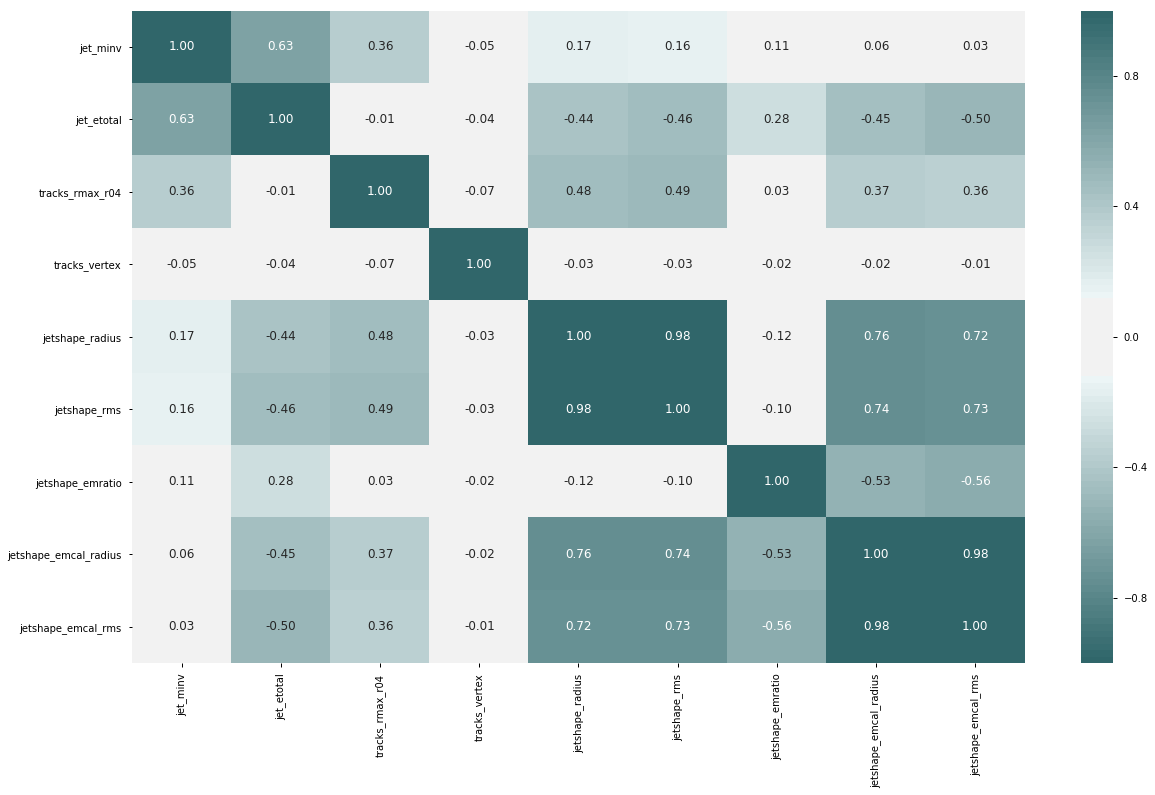

In [19]:
# display correlation parameters for pairs of paramter as heatmap
with sns.plotting_context("notebook", font_scale=1.0 ):
    fig = plt.figure(figsize=(20, 12))
    ax = sns.heatmap(df_select[feature_cols].corr(),
                     vmin=-1,vmax=1,annot=True, fmt=".2f", cmap=sns.diverging_palette(200, 200, l=40, sep=30, n=100))
    ax.set(xlabel='', ylabel='')
    plt.show()

The correlations between most selected feature columns are small.

### Creating training and test data from feature and target columns

In [20]:
# create subsets of training and test data with feature and target columns
X_train = df_train[ feature_cols ]
y_train = df_train[ target_col ]
X_test = df_test[ feature_cols ]
y_test = df_test[ target_col ]

### Model selection

Load additional libraries for models:

In [21]:
# load additional libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In order to quickly test various models to see which one may perform best, we create an array with several models and their descriptions. We loop over the array to test all the included models.

In [22]:
# create array of models and their names / descriptions to quickly loop over them
models = []

# Decision tre classifier
models.append(('Decision Tree', DecisionTreeClassifier()))

# Decision tree classifier with penalties and maximum depth
penalty = {
    0: 1,
    1: 10
}
maxdepth = 10
models.append(("DecisionTree with Penalties (%d, %d) and Max Depth (%d)" % (penalty[0],penalty[1],maxdepth),
               DecisionTreeClassifier(class_weight=penalty, max_depth=maxdepth) ))

# Decision tree classifier with penalties and maximum depth
penalty = {
    0: 10,
    1: 1
}
maxdepth = 10
models.append(("DecisionTree with Penalties (%d, %d) and Max Depth (%d)" % (penalty[0],penalty[1],maxdepth),
               DecisionTreeClassifier(class_weight=penalty, max_depth=maxdepth) ))

# RandomForest Classifier
penalty = {
    0: 10,
    1: 1
}
models.append(("RandomForest with Penalties (%d, %d)" % (penalty[0],penalty[1]),
               RandomForestClassifier(class_weight=penalty, random_state=1) ))

# AdaBoost Classifier
models.append(("AdaBoost", AdaBoostClassifier(random_state=1) ))

### Training and testing selected models

Loop over models defined in array and see how they perform:

In [23]:
# evaluate each model in turn
for name, model in models:
    print( "Testing model: ", name )
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print_efficiencies( y_train, y_train_pred, y_test, y_test_pred )
    print( "------------------------------------------------------------------------------------" )

Testing model:  Decision Tree
Model train/test true positives: 1516.000 / 5730.000 (1.00000 / 0.92884)
Model train/test false positives 0.000 / 549.000 (0.00000 / 0.04412)
Model train/test true negatives 3006.000 / 11895.000
Model train/test false negatives 0.000 / 439.000
------------------------------------------------------------------------------------
Testing model:  DecisionTree with Penalties (1, 10) and Max Depth (10)
Model train/test true positives: 1516.000 / 5882.000 (1.00000 / 0.95348)
Model train/test false positives 139.000 / 940.000 (0.04624 / 0.07554)
Model train/test true negatives 2867.000 / 11504.000
Model train/test false negatives 0.000 / 287.000
------------------------------------------------------------------------------------
Testing model:  DecisionTree with Penalties (10, 1) and Max Depth (10)
Model train/test true positives: 1387.000 / 5472.000 (0.91491 / 0.88702)
Model train/test false positives 0.000 / 248.000 (0.00000 / 0.01993)
Model train/test true nega

Some of the chosen DecisionTree classifiers show 100% true positives and 0% false positives on the training data, but worse performance of the test data. This is a strong indication of overtraining of the model. Next, we will look at how the model performance on the training data depends on the chosen hyperparameters.

###  Hyperparameter optimization
The DecisionTree classifier with penalties and maximum depth allows to optimize these parameters for the task of minimizing false positives while maximizing true positives in the tau classification.

In [24]:
# create array of models and their names / descriptions to quickly loop over them
trees_var_depth = []

# create array of tree depths to test
tree_depths = np.arange(1,100)

# Decision tree classifier with penalties and maximum depth
penalty = {
    0: 10,
    1: 1
}

# loop over various max_depth values and add decision trees with those values to array
for maxdepth in tree_depths:
    trees_var_depth.append(("Decision Tree with Penalties (%d, %d) and Max Depth (%d)" % (penalty[0],penalty[1],maxdepth),
                            DecisionTreeClassifier(class_weight=penalty, max_depth=maxdepth) ))

Loop over DecisionTree classifiers with different max_depth settings and collect the performance indicators in arrays. Plot the true positive rates and false positive rates as function of the max_depth model parameter.

In [25]:
# arrays to store true positive and false positive fractions
tree_vardepth_tp = []
tree_vardepth_fp = []

# evaluate each model in turn
for name, model in trees_var_depth:
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    tree_vardepth_tp.append( true_positives( y_train, y_train_pred ) )
    tree_vardepth_fp.append( false_positives( y_train, y_train_pred ) )

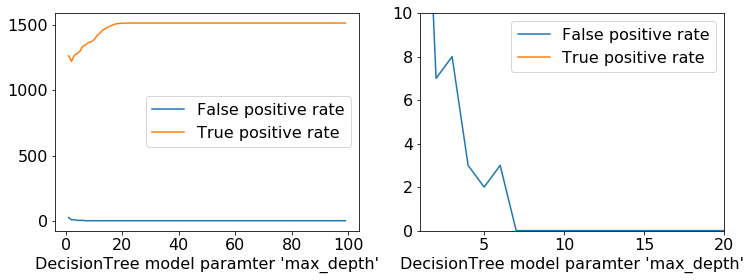

In [26]:
# plot true positive rate and false positive rate as function of chosen max_depth of decision tree
plt.figure(figsize=(12,4))

ax = plt.subplot(1,2,1)
plt.plot(tree_depths, tree_vardepth_fp, label='False positive rate')
plt.plot(tree_depths, tree_vardepth_tp, label='True positive rate')
plt.legend(loc='best')
ax.set_xlabel('DecisionTree model paramter \'max_depth\'')

ax = plt.subplot(1,2,2)
plt.plot(tree_depths, tree_vardepth_fp, label='False positive rate')
plt.plot(tree_depths, tree_vardepth_tp, label='True positive rate')
plt.legend(loc='best')
ax.set_xlabel('DecisionTree model paramter \'max_depth\'')
ax.set_xlim([1,20])
ax.set_ylim([0,10])

plt.show()

The false positive rate decreases and the true positive rates increases with increasing max_depth parameter of the DecisionTree model. At around max_depth=20 the true positive rate reaches a plateau. The close-up view of the false positive rates at low values of max_depth shown on the right shows a drop in false positives even for small values of max_depth. We choose max_depth=3 for the decision tree model.

Loop over DecisionTree classifiers with different penalty settings and collect the performance indicators in arrays. Plot the true positive rates and false positive rates as function of the penalty(1) model parameter.

In [27]:
# create array of models and their names / descriptions to quickly loop over them
trees_var_penalty = []

# create array of tree depths to test
#tree_penalties = [10**x for x in np.arange(0,100)]
tree_penalties = np.arange(1,100)

# choose maxdepth
maxdepth=3

# loop over various max_depth values and add decision trees with those values to array
for penalty in tree_penalties:
    
    penalty = {
        0: penalty,
        1: 1
    }
    
    trees_var_penalty.append(("Decision Tree with Penalties (%d, %d) and Max Depth (%d)" % (penalty[0],penalty[1],maxdepth),
                            DecisionTreeClassifier(class_weight=penalty, max_depth=maxdepth) ))
    
# arrays to store true positive and false positive fractions
tree_varpenalty_tp = []
tree_varpenalty_fp = []

# evaluate each model in turn
for name, model in trees_var_penalty:
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    tree_varpenalty_tp.append( true_positives( y_train, y_train_pred ) )
    tree_varpenalty_fp.append( false_positives( y_train, y_train_pred ) )

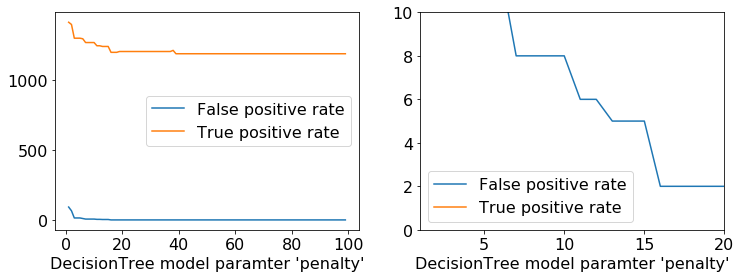

In [28]:
# plot true positive rate and false positive rate as function of chosen penalty of decision tree
plt.figure(figsize=(12,4))

ax = plt.subplot(1,2,1)
plt.plot(tree_penalties, tree_varpenalty_fp, label='False positive rate')
plt.plot(tree_penalties, tree_varpenalty_tp, label='True positive rate')
plt.legend(loc='best')
#ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('DecisionTree model paramter \'penalty\'')

ax = plt.subplot(1,2,2)
plt.plot(tree_penalties, tree_varpenalty_fp, label='False positive rate')
plt.plot(tree_penalties, tree_varpenalty_tp, label='True positive rate')
plt.legend(loc='best')
#ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('DecisionTree model paramter \'penalty\'')
ax.set_xlim([1,20])
ax.set_ylim([0,10])

plt.show()

Both the true positive and flase positive rates falls with increasing penalty for false positives. The right plot shows a close-up view of the false positive rate at low penalty values. We choose penalty=10 for the Decision Tree model.

Test the DecisionTree model with the optimized parameters:

In [29]:
# Decision tree classifier with penalties and maximum depth
penalty = {
    0: 10,
    1: 1
}
maxdepth = 3
model_opt = DecisionTreeClassifier(class_weight=penalty, max_depth=maxdepth)

model_opt.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print_efficiencies( y_train, y_train_pred, y_test, y_test_pred )

Model train/test true positives: 1189.000 / 4898.000 (0.78430 / 0.79397)
Model train/test false positives 2.000 / 39.000 (0.00067 / 0.00313)
Model train/test true negatives 3004.000 / 12405.000
Model train/test false negatives 327.000 / 1271.000


The false positive rate of the DecisionTree model with optimized hyperparameters is lower than the value we got with our initially chosen parameters. The true positive rate drops less, so given that for this study rejecting background events is more important then registering all signal events, this is an improvement of the model performance.

### A closer look at the AdaBoost classifier
Above we only used the AdaBoost classifier with its default parameters. Now we will have a closer look at how to optimize the AdaBoost performance by handling it a defined DecisionTreeClassifier. AdaBoost is particularly powerful when used with relatively weak DecisionTreeClassifiers, i.e. DecisionTreeClassifiers that have a rather small max_depth and may in itself not have a great separation power of signal and background events.

In [30]:
penalty = {
    0: 10,
    1: 1
}
tree2 = DecisionTreeClassifier(class_weight=penalty,
                               criterion='entropy',
                               random_state=1,
                               max_depth=1)

ada2 = AdaBoostClassifier(base_estimator=tree2,
                          n_estimators=100,
                          learning_rate=0.1,
                          random_state=1)

tree2 = tree2.fit(X_train,y_train)
y_train_pred_tree2 = tree2.predict(X_train)
y_test_pred_tree2 = tree2.predict(X_test)

# Visualize tree
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz( tree2,
                            filled=True,
                            class_names=['Signal',
                                         'Background'],
                            feature_names=feature_cols,
                            out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png('figures/example_tree2.png')


print('Decision tree performance:')
print_efficiencies( y_train, y_train_pred_tree2, y_test, y_test_pred_tree2 )
print('---------------')

ada2 = ada2.fit(X_train,y_train)
y_train_pred_ada2 = ada2.predict(X_train)
y_test_pred_ada2 = ada2.predict(X_test)

print('AdaBoost performance:')
print_efficiencies( y_train, y_train_pred_ada2, y_test, y_test_pred_ada2 )

Decision tree performance:
Model train/test true positives: 1292.000 / 5266.000 (0.85224 / 0.85362)
Model train/test false positives 30.000 / 143.000 (0.00998 / 0.01149)
Model train/test true negatives 2976.000 / 12301.000
Model train/test false negatives 224.000 / 903.000
---------------
AdaBoost performance:
Model train/test true positives: 1236.000 / 5031.000 (0.81530 / 0.81553)
Model train/test false positives 9.000 / 41.000 (0.00299 / 0.00329)
Model train/test true negatives 2997.000 / 12403.000
Model train/test false negatives 280.000 / 1138.000


This is the visualization of the __tree2__ DecisionTreeClassifier after training on the training data:
<img src="figures/example_tree2.png" alt="Example Decision Tree visualization." style="width: 400px;"/>

The AdaBoost classifier with optimized settings and input DecisionTree object performs well on the test data. Using our model to predict the signal (tau) and background (hadron) jets in the test sample yields comparable true positive and false positive fractions as the result on the training data itself from the previous section. This indicates that our model is robust and has not been overtrained on the training data.

# 5 Evaluating algorithm for tau jet classification

With the AdaBoost classifier with optimized settings and input DecisionTree object, we achieve (on the test data):

In [31]:
print( "True positive fraction: %.2f percent"
      % (100*true_positives( y_test, y_test_pred_ada2 )/ len(y_test[ y_test == 1 ])) )
print( "False positive fraction: %.2f percent"
      % (100*false_positives( y_test, y_test_pred_ada2 )/ len(y_test[ y_test == 0 ])) )

True positive fraction: 81.55 percent
False positive fraction: 0.33 percent


As a reminder, the cut-based selection yields 0.1% false positives fraction at 45% true positives fraction. The AdaBoost model yields 0.3% false positives fraction at 82% true positives fraction. The AdaBoost classifier retains a significantly higher true positive rate at comparable false positive rate.

Neither of these methods could reliably identify a single tau jet in a background of over 100 million hadron jets. However, in an analysis of EIC data, the tau identification is only one step of the overall event classification. In addition to finding a tau candidate, analyzing event topologies (like the angle between multiple jets found in a single electron-proton collision) will help to reduce the false positive rate, i.e. the misidentification of 'Standard Model' background events as 'Beyond the Standard Model' electron-to-tau conversion events.

Moreover, the design of the experiment and development of reconstruction algorithms are still evolving. By the time the EIC actually starts operating, the capabilities of the experiment itself to measure energies, charged tracks, and jets may have improved. This would lead to a better quality of input data for tau identification. For example, a more precise jet energy measurement by the experiment could reduce the widths of the signal and background distributions shown in the section on cut-based selection of this study. The reduced widths would improve the separation of signal and background.

# Next steps
* Try different combinations of selected feature columns to improve the tau classification.
* Normalize the data to a common range. This might help in training the machine learning algorithms.
* Try hyperparameter optimization for the RandomForest classifier.
* Try different machine learning algorithms.
* Adjust the cuts of the cut-based selection to try to increase true positive rate while further reducing false posive rate.
* Simulate larger data samples. These will be necessary to fully evaluate the tau selection and rejection of background events that are 100 million times more frequent than signal events.
* Improve the quality of the input data by improving the energy measurement and reconstruction of tracks and jets in the experiment.
* In addition to comparing individual signal and background jets, reconstruct the full electron-proton collision events (including, for example, angles between multiple jets) and evaluate the overall efficiencies to separate electron-to-tau conversion events from Standard Model background events.